Definiremos un modelo de Machine Learning para poder predecir la poblacion de años requeridos para nuestro analisis (2016 al 2021), datos que no existen mas podemos hacer una inferencia y poder tener esta información.

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pyarrow as pa
import pyarrow.parquet as pq
import warnings
warnings.simplefilter("ignore")

In [2]:
#importamos la base de datos de poblacion de wikipedia
poblawikidf = pq.read_table("../0-DATA/PoblacionBA.parquet").to_pandas()
poblawikidf

,Año,Poblacion
0,1779,24205
1,1810,44800
2,1869,177797
3,1895,663854
4,1914,1575814
5,1947,2981043
6,1960,2966634
7,1970,2972453
8,1980,2922829
9,1991,2965403


In [3]:
poblawikidf.columns

Index(['Año', 'Poblacion'], dtype='object')

Generamos un modelo de regresion lineal para calcular los años que no tenemos

Población pronosticada para el año 2016: 3287439
Población pronosticada para el año 2017: 3303150
Población pronosticada para el año 2018: 3318862
Población pronosticada para el año 2019: 3334573
Población pronosticada para el año 2020: 3350284
Población pronosticada para el año 2021: 3365995


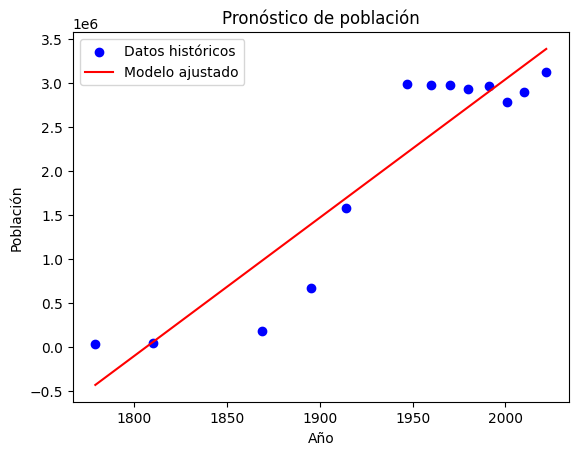

In [4]:
# Supongamos que tienes un DataFrame llamado 'df' con las columnas 'año' y 'poblacion'
# Aquí debes cargar tus datos históricos de población en un DataFrame 'df'

# Crear modelo de regresión lineal
modelo = LinearRegression()

# Ajustar el modelo a tus datos históricos
X = poblawikidf[['Año']]  # Variable independiente (años)
y = poblawikidf['Poblacion']  # Variable dependiente (población)
modelo.fit(X, y)

# Pronosticar la población para varios años futuros
años_futuros = [2016,2017,2018,2019,2020, 2021]  # Lista de años para los que deseas hacer los pronósticos
poblaciones_predichas = modelo.predict([[año] for año in años_futuros])

# Imprimir los pronósticos para cada año futuro
for año, poblacion_predicha in zip(años_futuros, poblaciones_predichas):
    print(f"Población pronosticada para el año {año}: {int(poblacion_predicha)}")

# Graficar los datos históricos y el modelo ajustado
plt.scatter(X, y, color='blue', label='Datos históricos')
plt.plot(X, modelo.predict(X), color='red', label='Modelo ajustado')
plt.xlabel('Año')
plt.ylabel('Población')
plt.title('Pronóstico de población')
plt.legend()
plt.show()


Como podemos ver, no nos da un numero acorde al crecimiento normal de la población, da el mismo resultado que un model cuadratico o cubico, o se deserie de tiempo y esto es debido a la falta de datos por lo cual no se entrena bien nuestro modelo.

#### Ya que un modelo no nos ayuda por datos insuficientes procedemos a calcular manualmente

In [6]:
#Estimacion de la poblacion aritmeticamente creciente desde 2010 al 2022
def estimar_poblacion(df, año_inicial=2010, año_final=2022):
    """
    Estima la población para los años intermedios entre año_inicial y año_final
    utilizando la diferencia promedio anual.

    Parámetros:
        df: DataFrame con las columnas 'Año' y 'Poblacion'.
        año_inicial: Año inicial para el cual se tiene información de población.
        año_final: Año final para el cual se tiene información de población.

    Retorna:
        DataFrame con los años intermedios y sus respectivas poblaciones estimadas.
    """
    # Se calcula la diferencia promedio anual entre el año_inicial y año_final
    poblacion_inicial = np.array(df[df["Año"] == año_inicial]["Poblacion"])
    poblacion_final = np.array(df[df["Año"] == año_final]["Poblacion"])
    diferencia_aniotoanio = (poblacion_final - poblacion_inicial) / (año_final - año_inicial)

    # Se estiman las poblaciones para los años intermedios
    poblaciones_estimadas = {}
    for año in range(año_inicial - 6, año_final):
        poblacion_estimada = int(poblacion_inicial + diferencia_aniotoanio * (año - año_inicial))
        poblaciones_estimadas[año] = poblacion_estimada

    # Se convierten las poblaciones estimadas a un DataFrame
    df_estimado = pd.DataFrame({'Año': list(poblaciones_estimadas.keys()),
                                'Poblacion': list(poblaciones_estimadas.values())})

    # Se concatena el DataFrame estimado con el original y se ordena por 'Año'
    df_completo = pd.concat([df, df_estimado], ignore_index=True).astype(int)
    df_completo = df_completo.sort_values(by='Año')

    return df_completo

# Ejemplo de uso:
# Suponiendo que 'df' es tu DataFrame original con las columnas 'Año' y 'Poblacion'
# df_ordenado = estimar_poblacion(df)


In [7]:
#creando nuestro DF con los años requeridos
df_ordenado = estimar_poblacion(poblawikidf, año_inicial=2010, año_final=2022)
df_ordenado = df_ordenado.drop(index=0)
df_ordenado = df_ordenado.reset_index(drop=True)
df_ordenado

,Año,Poblacion
0,1810,44800
1,1869,177797
2,1895,663854
3,1914,1575814
4,1947,2981043
5,1960,2966634
6,1970,2972453
7,1980,2922829
8,1991,2965403
9,2001,2776138


In [8]:
#guardamos en un CSV
df_ordenado.to_csv("../0-DATA/PoblacionBBDD.csv", index=False, encoding="utf-8") 

In [9]:
#Procedemos de la misma manera guardando en un archivo .parquet
itemsl = pd.read_csv("../0-DATA/PoblacionBBDD.csv") 
tabla = pa.Table.from_pandas(itemsl) 
pq.write_table(tabla,"../0-DATA/PoblacionBBDD.parquet") 